## KDT_AI-classifying prejudice and discrimination texts
https://www.kaggle.com/competitions/kdtai-2/overview

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

from torchinfo import summary

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt

import re
from konlpy.tag import Mecab

from gensim.models import word2vec

import sys
sys.path.append('..')

from python_scripts import data_setup, engine


In [2]:
idx_to_class = {
  0: 'Origin(출신차별)',
  1: 'Physical(외모차별) 외모(신체, 얼굴) 및 장애인 차별 발언을 포함합니다.',
  2: 'Politics(정치성향차별)',
  3: 'Profanity(혐오욕설) 욕설,저주,혐오 단어, 비속어 및 기타 혐오 발언을 포함합니다.',
  4: 'Age(연령차별)',
  5: 'Gender(성차별) 성별 또는 성적 취향에 대한 차별 발언을 포함합니다.',
  6: 'Not Hate Speech(해당사항없음)',
}

max_length = 200

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [4]:
train_data = pd.read_csv('../data/Discrimination/train.csv')
train_data

,ID,text,label
0,0,유소영비호감 성형아줌마,1
1,1,나오지마라 썅,3
2,2,식상하고 지긋지긋했는데 잘 끝나네 오예 소리벗고 빤스질러~~!!!,6
3,3,성희롱 당할 얼굴이 아닌데?ㅋㅋㅋ,5
4,4,"""끝까지 해보자~쪽파리 원숭이 자한 쓰레기당""",0
...,...,...,...
65858,65858,ㅋ ㅋ 쇼~~~ 도 적당히,6
65859,65859,"""이젠 전라도 종것들 음식 불매다. 태양광 중금속 환경오염물로 만든 식품 사절이다""",0
65860,65860,조센징들은 참 피곤하게 산다,0
65861,65861,"""문빠 다모아서 빨갱이한테보내고 행복하게살라고""",2


In [5]:
# train_data = train_data[train_data['label'].isin([0, 1])].reset_index(drop=True)
# train_data

In [6]:
max([len(s) for s in train_data['text']])

306

In [7]:
def preprocess_korean_text(text):
    # Remove URLs and mentions
    text = re.sub(r"(http|https)?:\/\/\S+\b|www\.(\w+\.)+\S*", "", text)
    text = re.sub(r"@(\w+)", "", text)

    # Tokenize text using Mecab
    mecab = Mecab()
    tokens = mecab.morphs(text)

    # Remove stop words (optional)
    stop_words = ["은", "는", "이", "가", "을", "를", "에", "의", "로", "으로", "에서"]
    tokens = [t for t in tokens if t not in stop_words]

    # Remove punctuation and non-Korean characters
    tokens = [re.sub(r"[^\u3131-\u3163\uac00-\ud7a3]+", "", t) for t in tokens]
    tokens = [t for t in tokens if t]

    return tokens

In [8]:
preprocess_korean_text('나는 지금 뭐하고 있느냐?')

['나', '지금', '뭐', '하', '고', '있', '느냐']

In [9]:
# tt = []
# for i in tqdm_notebook(range(len(train_data))):
#     tt.append(len(preprocess_korean_text(train_data.iloc[i]['text'])))

In [10]:
# plt.boxplot(tt)
# print(max(tt), min(tt), np.mean(tt), np.var(tt))
# print(np.sum(np.array(tt) > 100), '/', len(tt))

In [11]:
# Getting Word2Vec embedding pre-trained model

w2v_pretrained_model = word2vec.Word2Vec.load('../data/Discrimination/word2vec')
w2v_pretrained_model.wv.add_vector('<unk>', [0.0] * 100)

/Users/tglim/miniforge3/envs/tensorflow/lib/python3.8/site-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


358043

In [12]:
# Getting GloVe embedding pre-trained model

def load_glove_model(file):
    print("Loading Glove Weight")
    glove_vector = {}
    with open(file,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_vector[word] = embedding

    class Word_vector():
        def __init__(self, key_to_vector) -> None:
            self.key_to_vector = key_to_vector

            self.index_to_key = []
            self.key_to_index = {}
            for key in self.key_to_vector.keys():
                self.index_to_key.append(key)
                self.key_to_index[key] = len(self.index_to_key) - 1

            self.vectors = []
            for i in range(len(self.index_to_key)):
                self.vectors.append(self.key_to_vector[self.index_to_key[i]])
            self.vectors = np.array(self.vectors, dtype='float32')

            self.vector_size = len(self.vectors[0])

        def __contains__(self, key):
            return key in self.key_to_vector

        def __getitem__(self, key):
            return self.key_to_vector[key]

        def __len__(self):
            return len(self.index_to_key)

    class Glove_model():
        def __init__(self, vector) -> None:
            self.wv = Word_vector(vector)

        def __len__(self):
            return len(self.wv)

    glove_model = Glove_model(glove_vector)

    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_pretrained_model = load_glove_model('../data/Discrimination/glove.txt')
len(glove_pretrained_model.wv.index_to_key)

Loading Glove Weight
358043 words loaded!


358043

In [13]:
class KoreanTextDataset(Dataset):
    def __init__(self, data, embed_model, preprocess_korean_text, max_length=100):
        self.data = data
        self.max_length = max_length
        self.preprocess_korean_text = preprocess_korean_text
        self.model = embed_model
        self.idx_to_class = sorted(data['label'].unique())
        self.class_to_idx = {}
        for i in range(len(self.idx_to_class)):
            self.class_to_idx[self.idx_to_class[i]] = i
        self.class_names = self.idx_to_class

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.loc[index, "text"]
        label = self.data.loc[index, "label"]

        # Preprocess text using the preprocess_korean_text() function
        tokens = self.preprocess_korean_text(text)
        # Truncate or pad tokens to a fixed length
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            tokens += [""] * (self.max_length - len(tokens))

        # Convert tokens to indices using the pre-trained GloVe or Word2Vec embeddings
        indices = []
        for token in tokens:
            if token in self.model.wv:
                indices.append(self.model.wv.key_to_index[token])
            else:
                indices.append(self.model.wv.key_to_index['<unk>'])  # use the index of the <unk> token for out-of-vocabulary words

        return torch.tensor(indices), torch.tensor(label)

In [14]:
embed_model = w2v_pretrained_model

train_dataset = KoreanTextDataset(
    data=train_data,
    embed_model=embed_model,
    preprocess_korean_text=preprocess_korean_text,
    max_length=max_length
)

train_dataset_sub, val_dataset_sub = data_setup.split_dataset(
    dataset=train_dataset,
    split_size=0.9,
    seed=42
)

[INFO] Splitting dataset of length 65863 into splits of size: 59276 and 6587


In [15]:
class RNN_LSTM_attention(nn.Module):
    def __init__(self, embedding_model, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()

        vocab_size = len(embedding_model.wv.index_to_key)
        embedding_dim = embedding_model.wv.vector_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, _weight=torch.tensor(embedding_model.wv.vectors))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)

        if self.bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, output_dim)
            self.attention = nn.Linear(hidden_dim * 2, 1)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, text):
        # text = [batch size, seq len]

        embedded = self.embedding(text)
        # embedded = [batch size, seq len, emb dim]: [64, 300, 512]
        # print('embedded: ', embedded.shape)

        # packed_input = pack_padded_sequence(embedded, lengths)

        outputs, (hidden, _) = self.lstm(embedded.permute(1, 0, 2))
        # output = [batch size, seq len, hid dim * num directions]: [300, 64, 512]
        # hidden/cell = [num layers * num directions, batch size, hid dim]: [2, 64, 512]
        # print('outputs, hidden: ', outputs.shape, hidden.shape)

        # if self.bidirectional:
        #     hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) #.unsqueeze(1).repeat(1, text.shape[1], 1)
        # else:
        #     hidden = hidden[-1,:,:] #.unsqueeze(1).repeat(1, text.shape[1], 1)
        # hidden = [batch size, hid dim * num directions]: [64, 300, 512]
        # print('hidden: ', hidden.shape)

        attention_weights = F.softmax(self.attention(outputs.permute(1, 0, 2)), dim=1)
        # # attention_weights = [batch size, seq len, 1]: [64, 300, 1]
        # print('attention_weights: ', attention_weights.shape)

        context_vector = torch.bmm(outputs.permute(1, 2, 0), attention_weights).squeeze(2)
        # # context_vector = [batch size, hid dim * num directions]: [64, 512]
        # print('context_vector: ', context_vector.shape)

        out = self.fc(self.dropout(context_vector))
        # out = [batch size, output dim]: [64, 7]
        # print('out: ', out.shape)

        return out


In [16]:
learning_rate_list = [1e-3, 1e-4, 1e-5] # 각 LR 별로 10 epoch 씩 연달아 학습 진행
weight_decay_list = [1e-4]
epochs_list = [10]
batch_size_list = [64]

In [17]:
class_names, num_classes = train_dataset.class_names, len(train_dataset.class_names)
class_names, num_classes

([0, 1, 2, 3, 4, 5, 6], 7)

In [18]:
model_w2v = RNN_LSTM_attention(
    embedding_model=w2v_pretrained_model,
    hidden_dim=512,
    output_dim=num_classes,
    num_layers=3,
    bidirectional=False,
    dropout=0.1
)

In [19]:
model_glove = RNN_LSTM_attention(
    embedding_model=glove_pretrained_model,
    hidden_dim=512,
    output_dim=num_classes,
    num_layers=3,
    bidirectional=False,
    dropout=0.1
)

In [20]:
summary(model_w2v), summary(model_glove)

(=================================================================
 Layer (type:depth-idx)                   Param #
 RNN_LSTM_attention                       --
 ├─Embedding: 1-1                         (35,804,400)
 ├─LSTM: 1-2                              5,459,968
 ├─Dropout: 1-3                           --
 ├─Linear: 1-4                            3,591
 ├─Linear: 1-5                            513
 Total params: 41,268,472
 Trainable params: 5,464,072
 Non-trainable params: 35,804,400
 =================================================================,
 Layer (type:depth-idx)                   Param #
 RNN_LSTM_attention                       --
 ├─Embedding: 1-1                         (35,804,300)
 ├─LSTM: 1-2                              5,459,968
 ├─Dropout: 1-3                           --
 ├─Linear: 1-4                            3,591
 ├─Linear: 1-5                            513
 Total params: 41,268,372
 Trainable params: 5,464,072
 Non-trainable params: 35,804,300
 ====

In [21]:
model = model_w2v

tuning_results = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='LSTM_attention_w2v_discrimination',
    train_dataset=train_dataset_sub,
    test_dataset=val_dataset_sub,
    class_names=class_names,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=False,
    device=device,
    gradient_accumulation_num=1,
    saving_max=True,
    metric_learning=False
)

LSTM_attention_w2v_discrimination_LR_0.001_WD_0.0001_BS_64_GA_1:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/927 [00:00<?, ?it/s]

test:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.7877, Train_acc: 0.3756 | Test_loss: 1.7461, Test_acc: 0.3874
[INFO] Saving model to: ../models/LSTM_attention_w2v_discrimination_LR_0.001_WD_0.0001_BS_64_GA_1_EPOCH_0_TEST-ACC_0.38744446635246277.pth


train:   0%|          | 0/927 [00:00<?, ?it/s]

test:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 1.7522, Train_acc: 0.3769 | Test_loss: 1.7312, Test_acc: 0.3874


train:   0%|          | 0/927 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/15570 [00:00<?, ?it/s]

133 0 13.616570327552987 112.99749035680739
55 / 15570


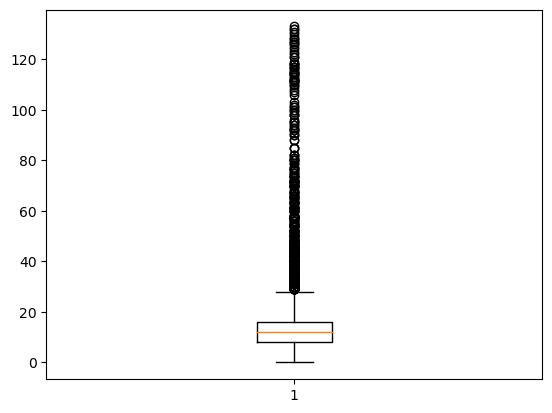

In [ ]:
# test_data = pd.read_csv('../data/Discrimination/test.csv')

# tt = []
# for i in tqdm_notebook(range(len(train_data))):
#     tt.append(len(preprocess_korean_text(train_data.iloc[i]['text'])))

# plt.boxplot(tt)
# print(max(tt), min(tt), np.mean(tt), np.var(tt))
# print(np.sum(np.array(tt) > 100), '/', len(tt))

In [22]:
test_data = pd.read_csv('../data/Discrimination/test.csv')
labels = []

model.eval()

with torch.inference_mode():
  for i in tqdm_notebook(range(len(test_data))):
    test_text = test_data.loc[i, "text"]
    test_tokens = preprocess_korean_text(test_text)
    if len(test_tokens) > max_length:
        test_tokens = test_tokens[:max_length]
    else:
        test_tokens += [""] * (max_length - len(test_tokens))

    indices = []
    for token in test_tokens:
      if token in embed_model.wv:
        indices.append(embed_model.wv.key_to_index[token])
      else:
        indices.append(embed_model.wv.key_to_index['<unk>'])  # use the index of the <unk> token for out-of-vocabulary words

    test_logits = model(torch.tensor(indices).unsqueeze(0).to(device))
    labels.append(class_names[torch.argmax(test_logits.squeeze(0).cpu())])

  0%|          | 0/13491 [00:00<?, ?it/s]

In [23]:
submission_data = pd.DataFrame({'ID': range(len(test_data)), 'label': labels})
submission_data.to_csv('../submissions/discrimination/submission.csv')
print('submission completed!')
submission_data.head()

submission completed!


,ID,label
0,0,6
1,1,6
2,2,6
3,3,6
4,4,6
